In [1]:
import torchvision, time, os, copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(), # flip horizontally 50% of the time - increases train set variability
        transforms.ToTensor(), # convert it to a PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet models expect this norm
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = '.'

In [4]:
# Create train and validation datasets and loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

['Negative', 'Positive', 'Undetectable']
cuda:0


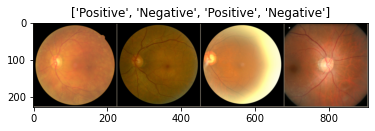

In [5]:
# Helper function for displaying images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Un-normalize the images
    inp = std * inp + mean
    # Clip just in case
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epoch_time = [] # we'll keep track of the time needed for each epoch

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    #model.load_state_dict(best_model_wts)
    return model, epoch_time

In [7]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [8]:
# Download a pre-trained ResNet18 model and freeze its weights
model = torchvision.models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
# Send the model to the GPU
model = model.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.00219, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.1)
model, epoch_time = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------


C:\Users\bahadur\.conda\envs\JetsonNano\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.5750 Acc: 0.4230
val Loss: 1.6158 Acc: 0.4277

Epoch 2/100
----------
train Loss: 1.4941 Acc: 0.4827
val Loss: 1.4748 Acc: 0.4827

Epoch 3/100
----------
train Loss: 1.4902 Acc: 0.5133
val Loss: 2.0160 Acc: 0.5127

Epoch 4/100
----------
train Loss: 1.4874 Acc: 0.4890
val Loss: 1.5402 Acc: 0.4743

Epoch 5/100
----------
train Loss: 1.7114 Acc: 0.4913
val Loss: 1.0541 Acc: 0.6000

Epoch 6/100
----------
train Loss: 1.5934 Acc: 0.5047
val Loss: 2.0278 Acc: 0.4770

Epoch 7/100
----------
train Loss: 1.4621 Acc: 0.5123
val Loss: 1.9044 Acc: 0.4477

Epoch 8/100
----------
train Loss: 1.4756 Acc: 0.5133
val Loss: 1.7616 Acc: 0.5027

Epoch 9/100
----------
train Loss: 1.4743 Acc: 0.5173
val Loss: 1.8607 Acc: 0.5167

Epoch 10/100
----------
train Loss: 1.3922 Acc: 0.5257
val Loss: 2.0721 Acc: 0.4463

Epoch 11/100
----------
train Loss: 1.4393 Acc: 0.5223
val Loss: 1.1549 Acc: 0.5767

Epoch 12/100
----------
train Loss: 1.4292 Acc: 0.5080
val Loss: 1.0265 Acc: 0.6063

Epoch 13/100

In [11]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

In [ ]:
#torch.save(model.state_dict(), 'checkpoint.pth')
#state_dict = torch.load('checkpoint.pth')
#print(state_dict.keys())
#model.load_state_dict(state_dict)

In [23]:
torch.save(model, 'FUll_model_weight.pth')

In [13]:
model = torch.load('FUll_model_weight.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(labels)

            outputs = model(inputs)
            print(outputs)
            _, preds = torch.max(outputs, 1)
            
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print(j)
                print(class_names[preds[j]])
                print(preds[j])
                print(class_names)
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

tensor([[-0.3813, -1.2976,  2.1357],
        [-0.3319, -1.7413,  1.9866],
        [ 1.0691, -0.2453,  0.1041],
        [ 0.3594,  0.3971,  0.1976]], device='cuda:0')
0
Undetectable
tensor(2, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


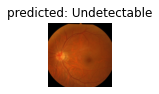

1
Undetectable
tensor(2, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


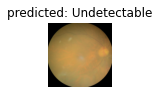

2
Negative
tensor(0, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


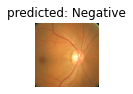

3
Positive
tensor(1, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


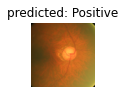

tensor([[ 0.4170, -0.3839,  0.7141],
        [-0.1354,  1.0286, -0.4210],
        [ 0.7570, -0.7967,  0.3918],
        [ 1.1179, -0.5353, -0.1155]], device='cuda:0')
0
Undetectable
tensor(2, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


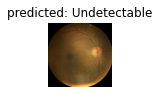

1
Positive
tensor(1, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


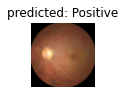

In [15]:
visualize_model(model)

tensor([[-0.6317, -0.7721,  1.5814]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor(2, device='cuda:0')


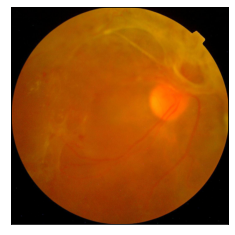

In [16]:
from PIL import Image
test_image = 'DR\val\Abnormal\1556_Abnormal.jpg'
labels = ['Negative', 'Positive', 'Undetectable']

# First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
#data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
data_transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224), transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# Load the image
image_ = Image.open(test_image)
plt.imshow(image_), plt.xticks([]), plt.yticks([])

# Now apply the transformation, expand the batch dimension, and send the image to the GPU
image = data_transform(image_).unsqueeze(0).cuda()

out = model(image)
#preds = torch.max(outputs, 1)
print(out)
print(out.argmax())

In [17]:
print("Predicted class is: {}".format(labels[out.argmax()]))
confidence = out[0][out.argmax()]
print("* confidence: {:.4f}".format(confidence))

Predicted class is: Undetectable
* confidence: 1.5814
